# Create a mean-reverting (Omstein Ublenbeck) data generating process

## Imports and Global Settings

Declaring all imports at the top of the notebook.

In [1]:
import warnings
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from numpy import ndarray
from scipy.integrate import quad
np.random.seed(0)
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

And then notebook-wide (global) settings that enable in-line plotting, configure Seaborn for visualisation and to explicitly ignore warnings (e.g. NumPy deprecations).

This is the solution to the following stochastic differential equation,

$$ d x_t = \theta( \mu - x_t) dt + \sigma dW_t $$

$$ X_t = X_0{\rm e}^{-\theta t} + \mu({1-{{\rm e}^{-\theta t}}}) + \sigma\int_0^t {e^{-\theta(t-s)}} \,{\rm d}W_s  $$

In [2]:
def ou(start: float,sigma:float, theta: float, mu: float, days:int) -> ndarray:

    dt = 1 / 250
    t = np.hstack([np.zeros(1), np.repeat(dt, days-1)]).cumsum()

    dw = np.random.normal(loc=0, scale=np.sqrt(dt), size=days-1)
    w = np.hstack([np.zeros(1), dw]).cumsum()

        # solve integration
    df = pd.DataFrame([np.arange(0,days,1),w]).T
    quad=[]
    for i in df.index:
        try:
            q = np.exp(theta*df.iloc[i,0])*(df.iloc[i+1,1]-df.iloc[i,1])
            quad.append(q)
        except:
            pass
    quad_sum = np.sum(quad)

    r_t = start*np.exp(-theta*days) + mu - mu*np.exp(-theta*days) + sigma*np.exp(-theta*days)*(quad_sum)
    return r_t

We now choose random values for an example OU time-series that we will then estimate using both maximum likelihood and Bayesian Inference.

In [3]:
#Start value,S0
start = 1.5

#Volatility
sigma = 1

#Mean-reverting speed
theta = 0.05

#long-term mean
mu = 2

days = 250

In [4]:
day_revert_mean=[]
for i in np.arange(1,days+1):
    v = ou(start,sigma,theta,mu,i)
    day_revert_mean.append(v)

In [11]:
example_data = pd.DataFrame({
    'Day': np.arange(1,251),
    'Return': day_revert_mean})

### Our mean ($\mu$) is 2

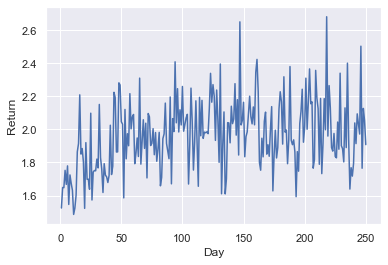

In [12]:
_ = sns.lineplot(x='Day', y='Return', data=example_data)

In [13]:
example_data.style.hide_index()

Day,Return
1,1.524385
2,1.648533
3,1.647439
4,1.752406
5,1.667438
6,1.779403
7,1.546043
8,1.724572
9,1.673628
10,1.632126
